# Topology optimization of a 2D heat sink
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/optimization/planar/topology_thermal_static.ipynb)

Inspired by [Dolfin Adjoint Tutorial](https://www.dolfin-adjoint.org/en/stable/documentation/poisson-topology/poisson-topology.html).


The model is defined on the square $\Omega$ with length $L=1\,\text{m}$. An homogenous heat source of $q=100\,\text{W}/\text{m}^2$ is applied to the solution domain.
Simple isotropic Fourier's law 
$$
\boldsymbol{h} = \kappa \mathrm{grad}\left( T \right)
$$
connects diffusive heat flux $\boldsymbol{h}$ and temperature gradient via the scalar conductivity $\kappa=400\,\mathrm{W}/\mathrm{m\,K}$.

Homogenous Neumann boundary conditions are prescribed at the `south` and `east` edges. 
A constant Dirichlet temperature boundary condition $T_D= 0\,\mathrm{K}$ is prescribed on the `west` and `north` edges.
Then, the Poisson-like PDE is defined as:

$$\begin{align}
\mathrm{div}\left( \boldsymbol{h} \right) + q =  0 \quad &\in \Omega,\\
\boldsymbol{h}\cdot\boldsymbol{n} = 0 \quad &\in \partial\Omega_\text{N},\\
T = T_\text{D} \quad &\in \partial\Omega_\text{D}.
\end{align}$$

In [1]:
import torch

from torchfem.mesh import rect_quad
from torchfem import PlanarHeat
from torchfem.materials import IsotropicConductivity2D

from matplotlib import animation
from torchfem.plot_utils import embed_animation_gif

from scipy.optimize import bisect
from tqdm import tqdm

torch.set_default_dtype(torch.double)

## Base problem without optimization 

Material model

In [2]:
# Thermal conductivity
kappa = 400.0

# Material model
material = IsotropicConductivity2D(kappa=kappa)

Geometry and model

In [3]:
# Edge length of domain
L = 1.0
# Number of elements per edge
n_elements = 300

# Create mesh
nodes, elements = rect_quad(n_elements + 1, n_elements + 1, L, L)

# Create model
model = PlanarHeat(nodes, elements, material)

Boundary conditions

In [4]:
# Heat source
q = 1000
# Dirichlet temperature
T_D = 0.0

# Apply Dirichlet boundary conditions at west and north edges
west = torch.isclose(nodes[:, 0], nodes[:, 0].min())
north = torch.isclose(nodes[:, 1], nodes[:, 1].max())
dirichlet_edges = west | north

model.constraints[dirichlet_edges] = True
model.displacements[dirichlet_edges] = T_D

# Compute fluxes due to heat source
element_volume = model.integrate_field()
cf = element_volume / element_volume.sum()
heat_source_per_element = cf * q

nodal_fluxes = (
    model.assemble_rhs(
        heat_source_per_element.unsqueeze(1).repeat(1, model.etype.nodes)
    )
    / model.etype.nodes
)

model.forces[:, 0] = nodal_fluxes

Solve the basic model

In [5]:
T, *_ = model.solve()

Visualize basic temperature distribution

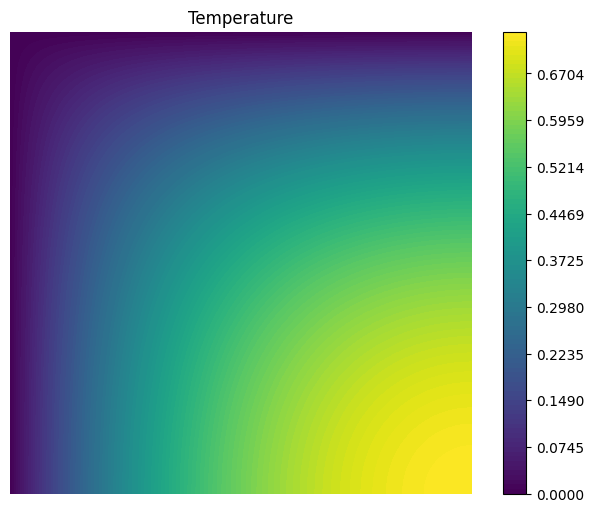

In [6]:
model.plot(
    node_property=T.squeeze(),
    linewidth=0.0,
    bcs=False,
    title="Temperature",
    colorbar=True,
)

## Optimization 

Instead of sensitivity filtering, we penalize the conventional objective $\mathcal{F}$ using Tikhonov regularization.

$$\mathcal{F} = \underline{T}\, \underline{f}^\top + \alpha \int_\Omega \left\lVert \frac{\partial \rho} {\partial \boldsymbol{x}} \right\rVert^2 \, \mathrm{d}V  $$

The first term is the "thermal compliance" Yet, some authors argue that it bears little physical interpretability (in contrast to mechanical compliance) and adjusting the objective to minimizing  the temperature variance being a more natural choice [[1]](https://doi.org/10.1109/TCPMT.2021.3120383). 

Under a minimal volume constraint the optimization problem reads:

$$
\min_{\rho \left( \boldsymbol{x} \right)} \left( \mathcal{F} \right)\quad\text{s.t.}\, \int_\Omega \rho \, \mathrm{d}V \leq V_0.
$$

To compute meaningful spatial gradients of the design varibale, we have to initialize $\rho$ at nodes and interpolate it to element centroids in the forward pass.


In [7]:
# Volume fraction
vol_frac = 0.4
# SIMP exponent
p = 3.0
# Move limit
move = 0.1
# Regularization parameter
alpha = 1.0
# Minimum thermal conductivity
kappa_min = 1.0

In [8]:
# evaluate N, N,x and detJ at element centroids
element_centroid = model.etype.ipoints.sum(dim=0)  # exploit regularity of the mesh
weight_sum = model.etype.iweights.sum()

N, B, detJ = model.eval_shape_functions(element_centroid)

# Initial, minimum, and maximum values of design variables
rho_nodes0 = vol_frac * torch.ones(len(nodes), requires_grad=True)
rho_min = kappa_min / kappa * torch.ones_like(rho_nodes0)
rho_max = torch.ones_like(rho_nodes0)

# Volume constraint
V_0 = vol_frac * element_volume.sum()

In [9]:
# runs for approx. 2 minutes on M1 MBA


def optimize(rho_nodes0, n_iter=50, alpha=0.0):
    rho_nodes = [rho_nodes0]
    temperature = []

    # Iterate solutions
    for k in tqdm(range(n_iter)):
        # Interpolate rho at element centroids
        rho_k = torch.einsum("EN, N -> E", rho_nodes[k][elements], N)
        # only for isotropic material -> same effect as updating kappa
        model.thickness = rho_k**p

        # Compute solution
        u_k, f_k, _, _, _ = model.solve()

        # Compute gradient of rho
        grad_rho = torch.einsum("EiN, EN -> Ei", B, rho_nodes[k][elements])
        regularization_term = torch.einsum("Ei, Ei, E ->", grad_rho, grad_rho, detJ)
        # Evaluation of compliance
        objective = torch.inner(f_k.ravel(), u_k.ravel()) + alpha * regularization_term
        # Automatic differentiation.
        sensitivity = torch.autograd.grad(objective, rho_nodes[k])[0]

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -sensitivity / mu
            # reasoning of OC may be violated here, clamping works to some extent :o
            G_k = G_k.clamp(min=0.0)
            upper = torch.min(rho_max, (1 + move) * rho_nodes[k])
            lower = torch.max(rho_min, (1 - move) * rho_nodes[k])
            rho_trial = G_k**0.5 * rho_nodes[k]
            return torch.maximum(torch.minimum(rho_trial, upper), lower)

        # Constraint function
        def g(mu):
            rho_nodes_it = make_step(mu)
            rho_k = torch.einsum("EN, N -> E", rho_nodes_it[elements], N)
            return torch.inner(element_volume, rho_k) - V_0

        # Find the root of g(mu)
        with torch.no_grad():
            mu = bisect(g, 0.0, 100000.0)

        rho_nodes.append(make_step(mu))
        temperature.append(u_k)

    return rho_nodes, temperature

In [10]:
rho_nodes, temperature = optimize(rho_nodes0, alpha=0.0)
rho_nodes_reg, temperature_reg = optimize(rho_nodes0, alpha=2.0)

100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


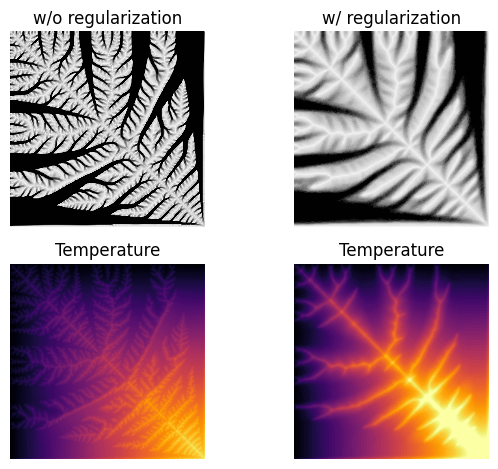

In [11]:
from matplotlib import pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
model.plot(
    node_property=rho_nodes[-1],
    cmap="gray_r",
    linewidth=0.0,
    bcs=False,
    ax=ax1,
    title="w/o regularization",
)
model.plot(
    node_property=rho_nodes_reg[-1],
    cmap="gray_r",
    linewidth=0.0,
    bcs=False,
    ax=ax2,
    title="w/ regularization",
)
model.plot(
    node_property=temperature[-1],
    cmap="inferno",
    linewidth=0.0,
    bcs=False,
    ax=ax3,
    title="Temperature",
)
model.plot(
    node_property=temperature_reg[-1],
    cmap="inferno",
    vmin=temperature[-1].min(),
    vmax=temperature[-1].max(),
    linewidth=0.0,
    bcs=False,
    ax=ax4,
    title="Temperature",
)
plt.tight_layout()